# Phase-Amplitude Coupling (PAC) Source Analysis for MEG Data

This notebook performs source-level PAC analysis on MEG data for saccade events.

## Analysis workflow:
1. **Data Loading**: Load source estimates and PAC results
2. **Morphing**: Transform individual data to fsaverage space
3. **ROI Analysis**: Extract PAC values for regions of interest
4. **Statistical Analysis**: Test significance across brain regions
5. **Visualisation**: Create brain plots and statistical summaries

**Author**: Philip Sulewski (psulewski@uos.de)

In [4]:
# Import required libraries
import sys
import os
import numpy as np
from pathlib import Path
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mne
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colors as mcolors

# Configure plotting
sns.set_context("poster")
color_peak = "#de5733ff"
plt.rcParams['svg.fonttype'] = 'none'

print("Libraries imported successfully!")

Libraries imported successfully!


## Configuration and Setup

In [11]:
# Subject and data configuration
subjects = [1, 2, 3, 4, 5]
event_types = ['saccade']
method = "beamformer"
surrogate_method = "single_cut"

# Memorability split configuration
use_memsplit = True  # Set to True to load memorability split data
memsplit_ratio = "40-40"  # e.g., "50-50" or "25-25" (only used if use_memsplit=True)

# Frequency bands
theta_freqs = (3, 8)
gamma_freqs = (40, 140)

# Time window for PAC analysis
time_window = [0.15, 0.4]

# Data paths
SUBJECTS_DIR = "/Users/atlas/avs/rawdir/"
avs_dir = "/Users/atlas/avs"
data_dir = "/Users/atlas/share_psulewski/psulewski/active-visual-semantics-MEG/results/fullrun/analysis/gazetime/revision_nature/ica/stc/filter_0.2_200/"

print(f"Analysis configuration:")
print(f"- Subjects: {subjects}")
print(f"- Theta band: {theta_freqs[0]}-{theta_freqs[1]} Hz")
print(f"- Gamma band: {gamma_freqs[0]}-{gamma_freqs[1]} Hz")
print(f"- Time window: {time_window[0]}-{time_window[1]} s")
print(f"- Memorability split: {'YES (' + memsplit_ratio + ')' if use_memsplit else 'NO'}")

Analysis configuration:
- Subjects: [1, 2, 3, 4, 5]
- Theta band: 3-8 Hz
- Gamma band: 40-140 Hz
- Time window: 0.15-0.4 s
- Memorability split: YES (40-40)


## ROI Definitions

Define anatomical regions of interest based on the Glasser atlas.

In [59]:
# Define compound ROI labels for analysis
compound_labels = {
    "early": ["early"],  # Early visual cortex
    "parietal": ["midparietal", "parietal"],
    "lateral": ["midlateral", "lateral"],  # Lateral visual cortex
    "ventral": ["midventral", "ventral"],  # Ventral visual cortex
    "HC": ["H"],  # Hippocampus
    "EC": ["EC"],  # Entorhinal cortex
    "FEF": ["FEF"],  # Frontal eye fields
    "dlPFC": ["8C", "8Av", "i6-8", "s6-8", "SFL", "8BL", "9p", "9a", "8Ad", 
              "p9-46v", "a9-46v", "46", "9-46d"],  # Dorsolateral prefrontal cortex
    "OFC": ["47s", "47m", "a47r", "11l", "13l", "a10p", "p10p", "10pp", 
            "10d", "OFC", "pOFC"],  # Orbitofrontal cortex
    "infFC": ["45", "IFJp", "IFJa", "IFSp", "IFSa", "47l", "p47r"],  # Inferior frontal cortex
    "mPFC": ["33pr", "p24pr", "a24pr", "p24", "a24", "p32pr", "a32pr", 
             "d32", "p32", "s32", "8BM", "9m", "10v", "10r", "25"]  # Medial prefrontal cortex
}

print(f"Defined {len(compound_labels)} ROI categories:")
for roi, labels in compound_labels.items():
    print(f"- {roi}: {len(labels)} sub-regions")

Defined 11 ROI categories:
- early: 1 sub-regions
- parietal: 2 sub-regions
- lateral: 2 sub-regions
- ventral: 2 sub-regions
- HC: 1 sub-regions
- EC: 1 sub-regions
- FEF: 1 sub-regions
- dlPFC: 13 sub-regions
- OFC: 11 sub-regions
- infFC: 7 sub-regions
- mPFC: 15 sub-regions


## Data Loading Functions

In [9]:
def load_subject_data(subject, event_type, data_dir, avs_dir, use_memsplit=False, memsplit_ratio="50-50"):
    """
    Load source estimate and PAC results for a single subject.
    
    Parameters
    ----------
    subject : int
        Subject number
    event_type : str
        Event type (e.g., 'saccade')
    data_dir : str
        Path to PAC results directory
    avs_dir : str
        Path to source estimates directory
    use_memsplit : bool
        Whether to load memorability split data
    memsplit_ratio : str
        Memorability split ratio (e.g., "50-50" or "25-25")
        
    Returns
    -------
    stc : mne.SourceEstimate
        Source estimate object
    pac_results : pd.DataFrame
        PAC results dataframe
    has_memsplit : bool
        Whether the loaded data contains memorability split groups
    """
    sub_name = f"as{subject:02d}"
    
    # Load source estimate
    stc_fname = (f"{avs_dir}/population_codes/{sub_name}/source_space/{method}/"
                f"glasser/ori_normal/hem_both/filter_0.2_200/ica/{sub_name}a_stcs_{event_type}")
    stc = mne.read_source_estimate(stc_fname)
    
    # Build PAC results filename
    base_fname = (f"pac_results_{subject}_stc_{event_type}_"
                  f"{theta_freqs[0]}-{theta_freqs[1]}_"
                  f"{gamma_freqs[0]}-{gamma_freqs[1]}_"
                  f"{time_window[0]}-{time_window[1]}_"
                  f"['saccade', 'fixation', 'saccade_post', 'fixation_post']_"
                  f"{surrogate_method}")
    
    # Add memsplit suffix if requested
    if use_memsplit:
        memsplit_str = memsplit_ratio.replace("/", "-")
        pac_results_fname = f"{base_fname}_memsplit_{memsplit_str}.csv"
    else:
        pac_results_fname = f"{base_fname}.csv"
    
    pac_results_path = os.path.join(data_dir, sub_name, pac_results_fname)
    
    # Check if file exists
    if not os.path.exists(pac_results_path):
        raise FileNotFoundError(
            f"PAC results file not found: {pac_results_path}\n"
            f"Please check:\n"
            f"  - use_memsplit = {use_memsplit}\n"
            f"  - memsplit_ratio = {memsplit_ratio}\n"
            f"  - Expected filename: {pac_results_fname}"
        )
    
    # Load PAC results
    pac_results = pd.read_csv(pac_results_path)
    
    # Check if split_group column exists
    has_memsplit = 'split_group' in pac_results.columns
    
    if use_memsplit and not has_memsplit:
        print(f"WARNING: use_memsplit=True but no 'split_group' column found in {pac_results_fname}")
    
    print(f"Loaded data for {sub_name}: {len(pac_results)} PAC values" + 
          (f" ({pac_results['split_group'].value_counts().to_dict()})" if has_memsplit else ""))
    
    return stc, pac_results, has_memsplit



def create_pac_stc(stc, pac_results, split_group=None):
    """
    Create source estimate with PAC values as data.
    
    Parameters
    ----------
    stc : mne.SourceEstimate
        Template source estimate
    pac_results : pd.DataFrame
        PAC results with 'channel' and 'pac' columns
    split_group : str, optional
        If provided, only use data from this split_group ('low_mem', 'high_mem', or 'all')
        
    Returns
    -------
    pac_stc : mne.SourceEstimate
        Source estimate with PAC values
    """
    pac_stc = stc.copy()
    
    # Filter by split_group if specified
    if split_group is not None and 'split_group' in pac_results.columns:
        pac_results = pac_results[pac_results['split_group'] == split_group].copy()
    
    # Remove duplicates (keep last value)
    pac_results_clean = pac_results.sort_values(by="channel")
    pac_results_clean = pac_results_clean.drop_duplicates(subset="channel", keep="last")
    pac_results_clean = pac_results_clean.set_index("channel")
    
    # Prepare PAC data array
    pac_data = np.full((pac_stc.data.shape[0], 1), np.nan)
    
    # Fill PAC values into source estimate
    channels = np.concatenate((stc.vertices[0], stc.vertices[1]))
    for i, channel in enumerate(channels):
        if i in pac_results_clean.index:
            pac_data[i] = pac_results_clean.loc[i]["pac"]
    
    pac_stc.data = pac_data
    n_nans = np.isnan(pac_data).sum()
    
    if n_nans > 0 and split_group:
        print(f"  Warning: {n_nans} vertices without PAC values for {split_group}")
    elif n_nans > 0:
        print(f"Warning: {n_nans} vertices without PAC values")
    
    return pac_stc

print("Data loading functions defined.")

Data loading functions defined.


## Main Data Loading

Load source estimates and PAC results for all subjects.

In [12]:
print("Loading data for all subjects...")
print("=" * 50)

stc_dict = {}
pac_results_dict = {}
has_memsplit_data = False

for subject in subjects:
    print(f"\nProcessing subject {subject}...")
    
    # Load data with memsplit configuration
    stc, pac_results, has_memsplit = load_subject_data(
        subject, 
        event_types[0], 
        data_dir, 
        avs_dir,
        use_memsplit=use_memsplit,
        memsplit_ratio=memsplit_ratio
    )
    
    # Track if any subject has memsplit data
    if has_memsplit:
        has_memsplit_data = True
    
    # Create PAC source estimate (using all data, will split later if needed)
    pac_stc = create_pac_stc(stc, pac_results)
    
    stc_dict[subject] = pac_stc
    pac_results_dict[subject] = pac_results

print(f"\nData loading complete!")
print(f"Source estimate shape: {stc_dict[1].data.shape}")
print(f"Number of vertices: {len(stc_dict[1].vertices[0]) + len(stc_dict[1].vertices[1])}")

if has_memsplit_data:
    print(f"\n*** Memorability split data loaded successfully ***")
    print(f"Ratio: {memsplit_ratio}")
    print("Will perform additional high vs low memorability analysis.")
else:
    print(f"\n*** Standard (non-split) data loaded ***")

Loading data for all subjects...

Processing subject 1...
Loaded data for as01: 516 PAC values ({'low_mem': 258, 'high_mem': 258})

Processing subject 2...
Loaded data for as02: 516 PAC values ({'low_mem': 258, 'high_mem': 258})

Processing subject 3...
Loaded data for as03: 354 PAC values ({'low_mem': 177, 'high_mem': 177})

Processing subject 4...
Loaded data for as04: 354 PAC values ({'low_mem': 177, 'high_mem': 177})

Processing subject 5...
Loaded data for as05: 352 PAC values ({'low_mem': 176, 'high_mem': 176})

Data loading complete!
Source estimate shape: (8196, 1)
Number of vertices: 8196

*** Memorability split data loaded successfully ***
Ratio: 40-40
Will perform additional high vs low memorability analysis.


## PAC Distribution Analysis

Visualise the distribution of PAC values before morphing to fsaverage space.

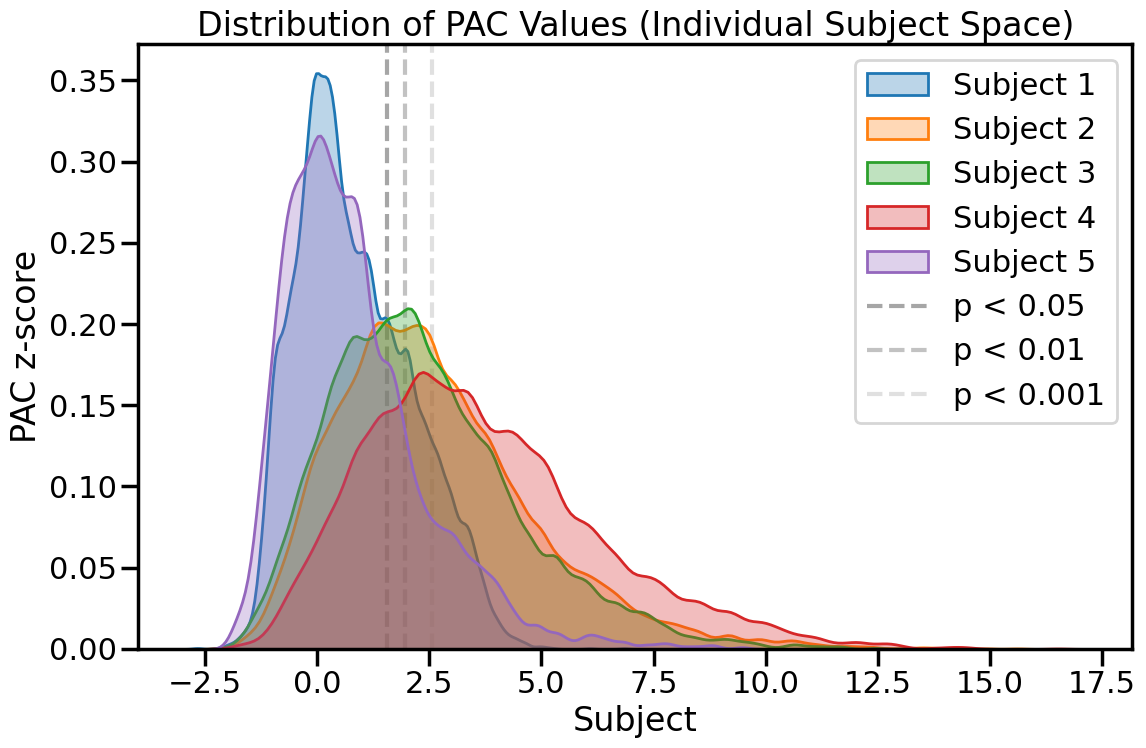


PAC Summary Statistics:
Mean: 2.291
Std: 2.348
Range: -2.670 to 16.525
Significant values (|z| > 1.65): 18355 / 33727 (54.4%)


In [62]:
plt.figure(figsize=(12, 8))
# make pac numeric

# make a kdeplot with hue for each subject
for subject in subjects:
    pac_data = pac_results_dict[subject]
    pac_data["pac"] = pd.to_numeric(pac_data["pac"], errors="coerce")
    # make a kdeplot with hue for each subject
    sns.kdeplot(data=pac_data, x="pac", fill=True, alpha=0.3, label=f"Subject {subject}", bw_adjust=0.5)

# Add significance thresholds
plt.axvline(x=1.56, color="grey", linestyle="--", alpha=0.7, label="p < 0.05", zorder = 0)
plt.axvline(x=1.96, color="darkgrey", linestyle="--", alpha=0.7, label="p < 0.01", zorder = 0) 
plt.axvline(x=2.56, color="lightgrey", linestyle="--", alpha=0.7, label="p < 0.001", zorder = 0)

plt.xlabel("Subject")
plt.ylabel("PAC z-score")
plt.title("Distribution of PAC Values (Individual Subject Space)")
#plt.ylim(-3, 20)
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
all_pac_values = pd.concat([pac_results_dict[s]["pac"] for s in subjects])
print(f"\nPAC Summary Statistics:")
print(f"Mean: {all_pac_values.mean():.3f}")
print(f"Std: {all_pac_values.std():.3f}")
print(f"Range: {all_pac_values.min():.3f} to {all_pac_values.max():.3f}")
print(f"Significant values (|z| > 1.65): {(np.abs(all_pac_values) > 1.65).sum()} / {len(all_pac_values)} ({(np.abs(all_pac_values) > 1.65).mean()*100:.1f}%)")

## Morphing to fsaverage Space

Transform individual subject data to common fsaverage space for group analysis.

In [63]:
print("Morphing individual data to fsaverage space...")
print("=" * 50)

stcs_fsaverage = {}

for subject in subjects:
    print(f"Morphing subject {subject} to fsaverage...")
    stc = stc_dict[subject]
    
    # Compute morphing and apply
    morph = mne.compute_source_morph(
        stc, 
        subject_from=f"as{subject:02d}", 
        subject_to='fsaverage', 
        subjects_dir=SUBJECTS_DIR
    )
    stc_fsaverage = morph.apply(stc)
    stcs_fsaverage[subject] = stc_fsaverage

print("Morphing complete!")

Morphing individual data to fsaverage space...
Morphing subject 1 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    7 smooth iterations done.
    8 smooth iterations done.
[done]
[done]
Morphing subject 2 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    8 smooth iterations done.
    8 smooth iterations done.
[done]
[done]
Morphing subject 3 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    8 smooth iterations done.
    8 smooth iterations done.
[done]
[done]
Morphing subject 4 to fsaverage...
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    8 smooth iterations done.
    9 smooth iterations done.
[done]
[done]
Morphing subject 5 to fsaverage...
su

## Group-Level Analysis

Analyse PAC patterns across all subjects in fsaverage space.

Group data shape: (5, 20484)

Group-level PAC Results:
- Vertices with significant PAC: 19452
- Vertices with 2+ subjects: 14483
- Vertices with 3+ subjects: 6126
- Vertices with 4+ subjects: 1399
- Vertices with all 5 subjects: 193


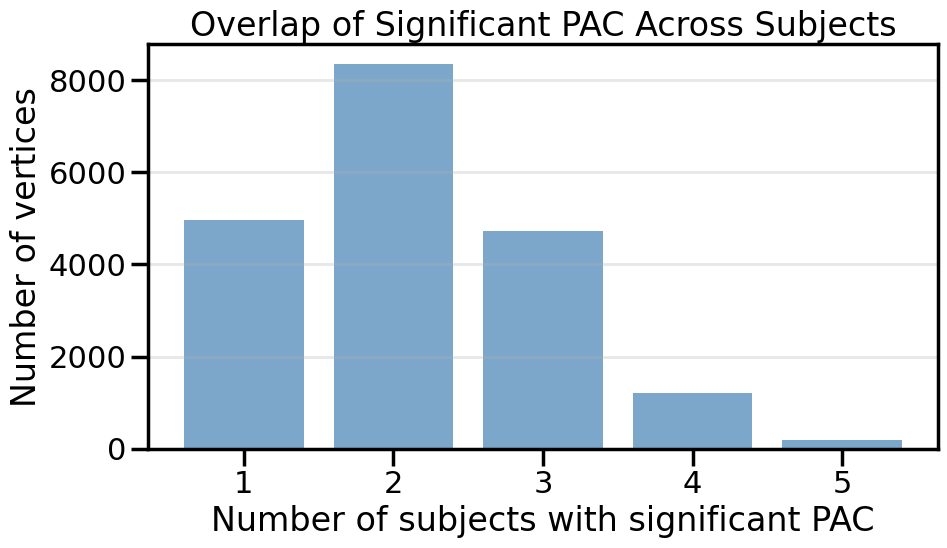

In [64]:
# Significance threshold
threshold = 1.65

# Collect all morphed data
all_stcs = np.array([stc.data[:, 0] for stc in stcs_fsaverage.values()])
print(f"Group data shape: {all_stcs.shape}")

# Count significant values per vertex
sig_count = np.sum(np.abs(all_stcs) > threshold, axis=0)

# Create count and average source estimates
sig_count_stc = list(stcs_fsaverage.values())[0].copy()
average_stc = list(stcs_fsaverage.values())[0].copy()

sig_count_stc.data = sig_count[:, np.newaxis]
average_stc.data = np.nanmean(all_stcs, axis=0)[:, np.newaxis]

# Report overlap statistics
sig_vertices = sig_count[sig_count > 0]
print(f"\nGroup-level PAC Results:")
print(f"- Vertices with significant PAC: {len(sig_vertices)}")
print(f"- Vertices with 2+ subjects: {np.sum(sig_count > 1)}")
print(f"- Vertices with 3+ subjects: {np.sum(sig_count > 2)}")
print(f"- Vertices with 4+ subjects: {np.sum(sig_count > 3)}")
print(f"- Vertices with all 5 subjects: {np.sum(sig_count > 4)}")

# Plot histogram of overlap counts
plt.figure(figsize=(10, 6))
unique_counts, count_frequencies = np.unique(sig_count[sig_count > 0], return_counts=True)
plt.bar(unique_counts, count_frequencies, alpha=0.7, color='steelblue')
plt.xlabel('Number of subjects with significant PAC')
plt.ylabel('Number of vertices')
plt.title('Overlap of Significant PAC Across Subjects')
plt.xticks(unique_counts)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## ROI Analysis Setup

Load anatomical labels and extract PAC values for each region of interest.

In [65]:
def load_roi_labels(subjects_dir, subject, compound_labels):
    """Load ROI labels for a subject."""
    labels_dict = {}
    
    for area in compound_labels.keys():
        labels_dict[area] = {}
        for hemi in ["lh", "rh"]:
            labels_dict[area][hemi] = []
            l_short = "R" if hemi == "rh" else "L"
            
            for roi in compound_labels[area]:
                label_fname = os.path.join(subjects_dir, subject, "label", 
                                         f"{hemi}.{l_short}_{roi}_ROI.label")
                
                if os.path.exists(label_fname):
                    label = mne.read_label(label_fname)
                    labels_dict[area][hemi].append(label)
                else:
                    print(f"Warning: Missing label {label_fname}")
    
    return labels_dict


def extract_pac_per_roi(stc_dict, labels_dict, compound_labels):
    """Extract PAC values per ROI for all subjects."""
    pac_per_label = pd.DataFrame()
    
    for subject in subjects:
        stc = stc_dict[subject]
        subject_labels = labels_dict[subject]
        
        for area, labels in subject_labels.items():
            for hemi, labels_list in labels.items():
                for label in labels_list:
                    # Extract data from label
                    stc_label = stc.in_label(label)
                    data_label = stc_label.data[:, 0]
                    
                    # Create dataframe entries
                    df_temp = pd.DataFrame({
                        'PAC': data_label,
                        'subject': subject,
                        'area': area,
                        'label': label.name,
                        'hemi': hemi
                    })
                    
                    pac_per_label = pd.concat([pac_per_label, df_temp], axis=0)
    
    return pac_per_label

print("ROI analysis functions defined.")

ROI analysis functions defined.


In [66]:
# Load labels for all subjects
print("Loading anatomical labels...")
labels_dict = {}
for subject in subjects:
    sub_name = f"as{subject:02d}"
    labels_dict[subject] = load_roi_labels(SUBJECTS_DIR, sub_name, compound_labels)

# Extract PAC values per ROI
print("\nExtracting PAC values per ROI...")
pac_per_label = extract_pac_per_roi(stc_dict, labels_dict, compound_labels)

# Remove NaN values and exclude problematic ROIs
pac_per_label = pac_per_label.dropna()
pac_per_label = pac_per_label[pac_per_label["area"] != "EC"]  # Exclude EC due to data issues

print(f"\nROI analysis data shape: {pac_per_label.shape}")
print(f"Areas analysed: {list(pac_per_label['area'].unique())}")
print(f"\nData points per area:")
print(pac_per_label.groupby('area').size().sort_values(ascending=False))

Loading anatomical labels...

Extracting PAC values per ROI...

ROI analysis data shape: (14374, 5)
Areas analysed: ['early', 'parietal', 'lateral', 'ventral', 'HC', 'FEF', 'dlPFC', 'OFC', 'infFC', 'mPFC']

Data points per area:
area
ventral     2627
dlPFC       2507
lateral     2226
mPFC        1498
OFC         1495
parietal    1492
early       1249
infFC        868
HC           242
FEF          170
dtype: int64


## Statistical Analysis

Apply statistical tests to determine significance of PAC patterns across brain regions.

In [67]:
print("Performing statistical analysis...")
print("=" * 50)

# Convert PAC z-scores to p-values
pac_per_label["p_value"] = pac_per_label["PAC"].transform(
    lambda x: 2 * (1 - scipy.stats.norm.cdf(np.abs(x)))
)

# Apply FDR correction within each subject
def apply_fdr_per_subject(group):
    """Apply FDR correction within a subject group."""
    _, fdr_p = mne.stats.fdr_correction(group["p_value"], alpha=0.05)
    return fdr_p

pac_per_label["fdr_p_value"] = pac_per_label.groupby("subject")["p_value"].transform(
    lambda x: mne.stats.fdr_correction(x, alpha=0.05)[1]
)

# Significance thresholds
p_threshold = 0.05
threshold_z = 1.65

# Calculate significance markers
pac_per_label["significant"] = pac_per_label["PAC"] > threshold_z
pac_per_label["significant_fdr"] = pac_per_label["fdr_p_value"] < p_threshold

print(f"Statistical summary:")
print(f"- Mean p-value: {pac_per_label['p_value'].mean():.4f}")
print(f"- Mean FDR-corrected p-value: {pac_per_label['fdr_p_value'].mean():.4f}")
print(f"- Uncorrected significant: {pac_per_label['significant'].sum()} / {len(pac_per_label)} ({pac_per_label['significant'].mean()*100:.1f}%)")
print(f"- FDR-corrected significant: {pac_per_label['significant_fdr'].sum()} / {len(pac_per_label)} ({pac_per_label['significant_fdr'].mean()*100:.1f}%)")

Performing statistical analysis...
Statistical summary:
- Mean p-value: 0.2145
- Mean FDR-corrected p-value: 0.2816
- Uncorrected significant: 8383 / 14374 (58.3%)
- FDR-corrected significant: 6743 / 14374 (46.9%)


In [68]:
# Calculate fraction of significant sources per ROI
sig_fraction = pac_per_label.groupby(["area", "hemi", "subject"]).agg({
    "significant_fdr": "mean"
}).reset_index()

# Test each ROI against chance (5%)
print("\nTesting ROIs against chance level (5%):")
print("-" * 40)

roi_tests = {}
for area in sig_fraction['area'].unique():
    area_data = sig_fraction[sig_fraction['area'] == area]["significant_fdr"]
    t_stat, p_val = scipy.stats.ttest_1samp(area_data, 0.05, alternative='greater')
    roi_tests[area] = {'t_stat': t_stat, 'p_val': p_val, 'mean_frac': area_data.mean()}
    print(f"{area}: t-stat = {t_stat:.3f}, p-value = {p_val:.4f}, mean fraction = {area_data.mean():.3f}")
    # Convert to dataframe and apply FDR correction
    test_results = pd.DataFrame.from_dict(roi_tests, orient='index').reset_index()
    test_results.columns = ['area', 't_stat', 'p_val', 'mean_frac']
    test_results['fdr_p_val'] = mne.stats.fdr_correction(test_results['p_val'], alpha=0.05)[1]
    test_results['significant'] = test_results['fdr_p_val'] < 0.05


Testing ROIs against chance level (5%):
----------------------------------------
FEF: t-stat = 2.330, p-value = 0.0241, mean fraction = 0.299
HC: t-stat = 3.908, p-value = 0.0022, mean fraction = 0.503
OFC: t-stat = 3.580, p-value = 0.0036, mean fraction = 0.448
dlPFC: t-stat = 4.206, p-value = 0.0015, mean fraction = 0.373
early: t-stat = 3.537, p-value = 0.0038, mean fraction = 0.360
infFC: t-stat = 4.962, p-value = 0.0006, mean fraction = 0.448
lateral: t-stat = 5.398, p-value = 0.0003, mean fraction = 0.439
mPFC: t-stat = 4.085, p-value = 0.0018, mean fraction = 0.499
parietal: t-stat = 3.938, p-value = 0.0022, mean fraction = 0.435
ventral: t-stat = 5.766, p-value = 0.0002, mean fraction = 0.530


## Mixed-Effects Statistical Model

Fit a mixed-effects model to account for between-subject variability.

In [69]:
# Prepare data for mixed-effects model
order_pac = pac_per_label.groupby("area")["PAC"].mean().sort_values(ascending=True).index
pac_per_label["area"] = pd.Categorical(pac_per_label["area"], categories=order_pac, ordered=True)

print("Fitting mixed-effects model...")
print("Model: PAC ~ area + (1|subject)")
print("-" * 30)

# Fit mixed-effects model with area as fixed effect and subject as random effect
try:
    model = smf.mixedlm("PAC ~ area", data=pac_per_label, groups=pac_per_label["subject"])
    result = model.fit()
    print(result.summary())
    
    # Extract and display key statistics
    print("\nModel Summary:")
    print(f"- Number of observations: {result.nobs}")
    print(f"- Number of groups (subjects): {result.n_groups}")
    print(f"- Log-likelihood: {result.llf:.3f}")
    print(f"- AIC: {result.aic:.3f}")
except Exception as e:
    print(f"Error fitting mixed-effects model: {e}")
    print("Proceeding with simpler analysis...")

Fitting mixed-effects model...
Model: PAC ~ area + (1|subject)
------------------------------
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PAC        
No. Observations: 14374   Method:             REML       
No. Groups:       5       Scale:              4.2585     
Min. group size:  906     Log-Likelihood:     -30835.7279
Max. group size:  3611    Converged:          Yes        
Mean group size:  2874.8                                 
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        1.527    0.510 2.994 0.003  0.527  2.527
area[T.early]    0.368    0.169 2.176 0.030  0.037  0.699
area[T.dlPFC]    0.259    0.164 1.585 0.113 -0.061  0.580
area[T.parietal] 0.442    0.167 2.646 0.008  0.115  0.770
area[T.lateral]  0.601    0.164 3.655 0.000  0.279  0.923
area[T.infFC]    0.621    0.173 3.590 0.000  0

## Visualisation: Fraction of Significant Sources

Plot the fraction of significant PAC sources per brain region.

/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_15650/2019271458.py:6: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.barplot(


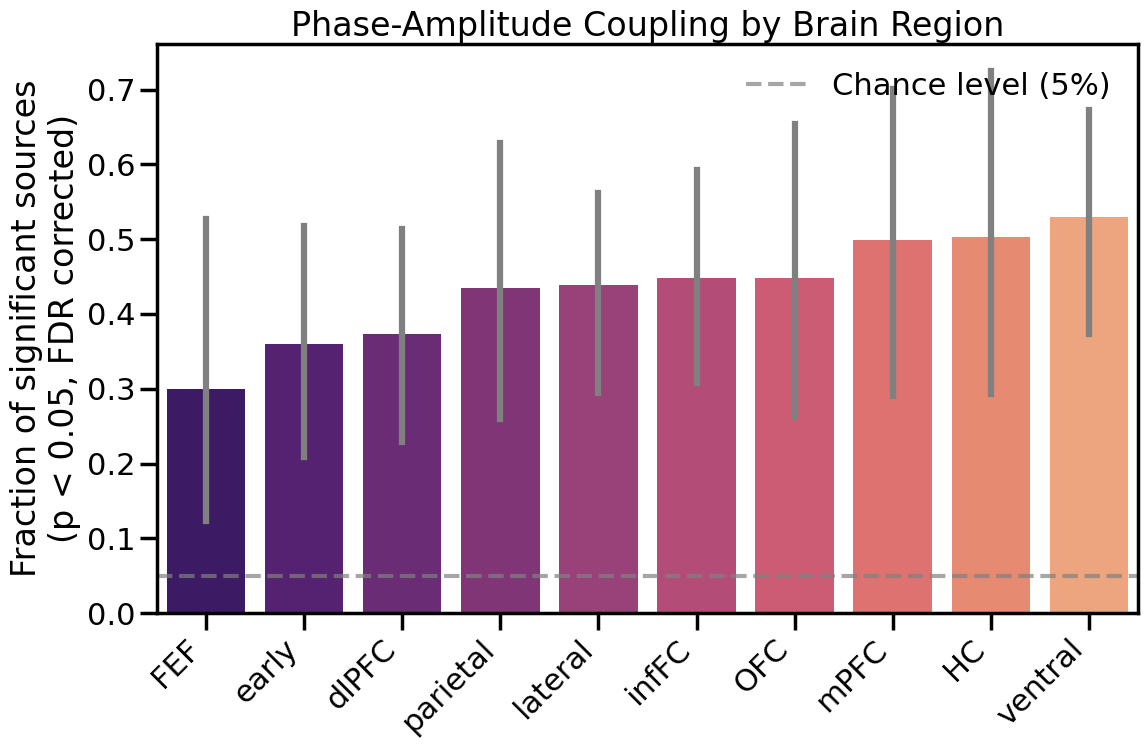

Figure saved as: pac_fraction_per_roi_3-8_40-140_0.15-0.4_fdr.png and pac_fraction_per_roi_3-8_40-140_0.15-0.4_fdr.pdf


In [70]:
# Create visualisation of significant fraction per ROI
order = sig_fraction.groupby("area")["significant_fdr"].mean().sort_values(ascending=True).index
palette = sns.color_palette("magma", n_colors=len(compound_labels.keys())+3)[2:-1]

plt.figure(figsize=(12, 8))
sns.barplot(
    data=sig_fraction, 
    x="area", 
    y="significant_fdr", 
    order=order, 
    palette=palette,
    ci=95,
    errcolor="grey"
)

plt.axhline(y=0.05, color="grey", linestyle="--", alpha=0.7, label="Chance level (5%)")
plt.ylabel(f"Fraction of significant sources\n(p < {p_threshold}, FDR corrected)")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.legend(loc="upper right", frameon=False)
plt.title("Phase-Amplitude Coupling by Brain Region")
plt.tight_layout()

# Save figure
fname = f"pac_fraction_per_roi_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}_{time_window[0]}-{time_window[1]}_fdr"
plt.savefig(fname + ".png", dpi=300, bbox_inches='tight')
plt.savefig(fname + ".pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as: {fname}.png and {fname}.pdf")

## Visualisation: Mean PAC Values

Plot the mean PAC z-scores by brain region and hemisphere.

/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_15650/4243185080.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(


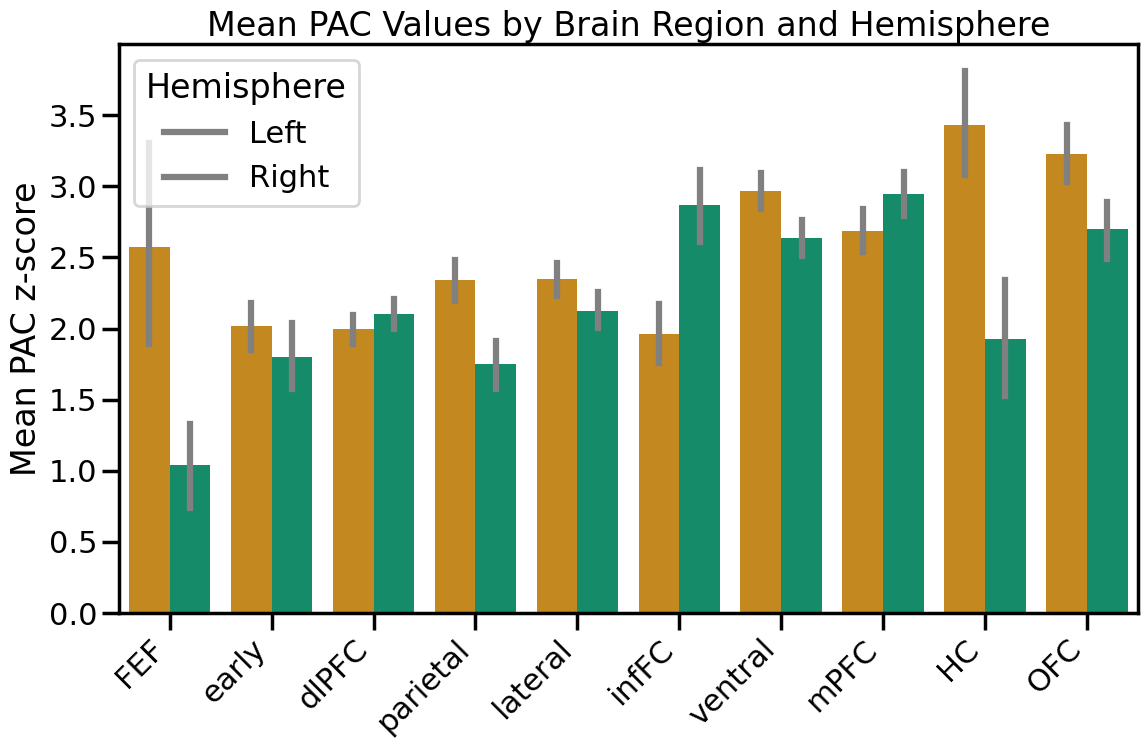

Figure saved as: pac_values_per_roi_3-8_40-140_0.15-0.4.png and pac_values_per_roi_3-8_40-140_0.15-0.4.pdf

Mean PAC values by region:
           mean    std  count
area                         
OFC       3.008  2.787   1495
HC        2.839  2.308    242
mPFC      2.816  2.128   1498
ventral   2.812  2.286   2627
infFC     2.382  2.423    868
lateral   2.242  2.160   2226
parietal  2.064  2.217   1492
dlPFC     2.045  1.901   2507
early     1.929  2.459   1249
FEF       1.854  2.777    170


In [71]:
# Create visualisation of mean PAC values per ROI
plt.figure(figsize=(12, 8))
order_pac = pac_per_label.groupby("area")["PAC"].mean().sort_values(ascending=True).index
palette_cb = sns.color_palette("colorblind", n_colors=10)[1:-1]

sns.barplot(
    data=pac_per_label,
    x="area",
    y="PAC", 
    hue="hemi",
    order=order_pac,
    palette=palette_cb,
    ci=95,
    errcolor="grey"
)

plt.ylabel("Mean PAC z-score")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.title("Mean PAC Values by Brain Region and Hemisphere")
plt.legend(title="Hemisphere", labels=["Left", "Right"])
plt.tight_layout()

# Save figure
fname = f"pac_values_per_roi_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}_{time_window[0]}-{time_window[1]}"
plt.savefig(fname + ".png", dpi=300, bbox_inches='tight')
plt.savefig(fname + ".pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure saved as: {fname}.png and {fname}.pdf")

# Print summary statistics
print("\nMean PAC values by region:")
mean_pac_summary = pac_per_label.groupby("area")["PAC"].agg(['mean', 'std', 'count']).round(3)
mean_pac_summary = mean_pac_summary.sort_values('mean', ascending=False)
print(mean_pac_summary)

Memorability Split Analysis

Subject 1: 258 low_mem, 258 high_mem sources

Subject 2: 258 low_mem, 258 high_mem sources

Subject 3: 177 low_mem, 177 high_mem sources

Subject 4: 177 low_mem, 177 high_mem sources

Subject 5: 176 low_mem, 176 high_mem sources

------------------------------------------------------------
Paired comparison results:
  Total paired sources: 1046
  Mean PAC (low mem): 1.442 ± 1.911
  Mean PAC (high mem): 1.349 ± 1.802
  Mean difference (high - low): -0.093 ± 1.279

  Paired t-test: t = -2.344, p = 0.0193


/var/folders/27/cgtzfw9j75bc116gkfsr71v00000gn/T/ipykernel_40604/2454316218.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pac_mem_long, x='mem_group', y='pac', palette='colorblind', ax=axes[0])


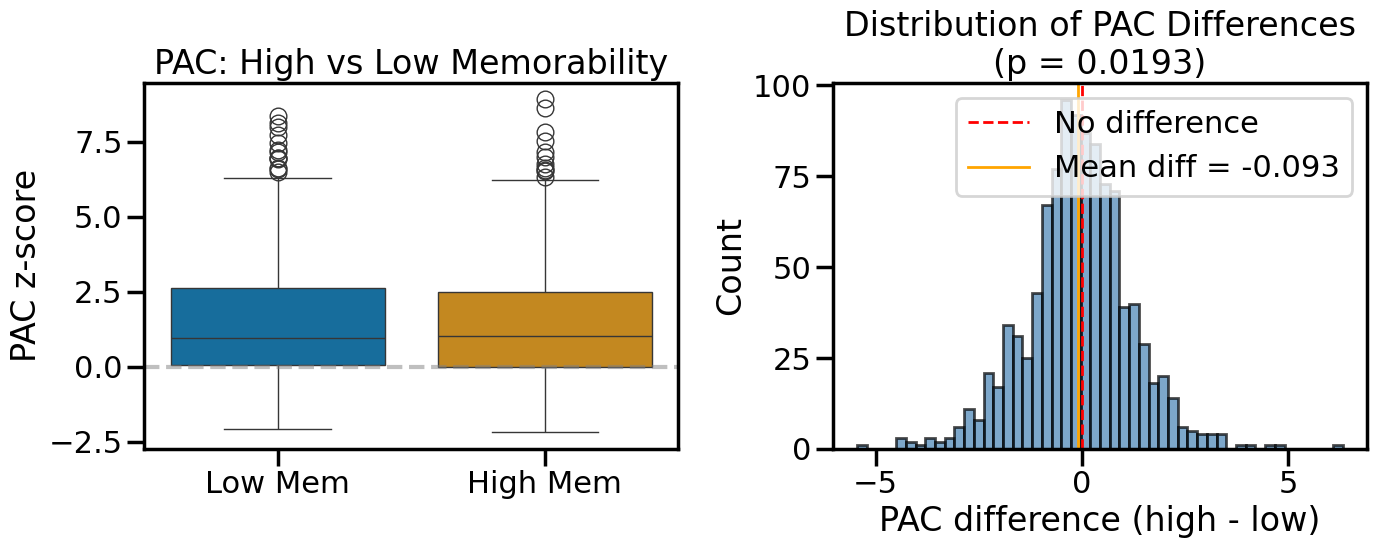


Figure saved as: pac_mem_comparison_3-8_40-140.png and pac_mem_comparison_3-8_40-140.pdf


In [13]:
if has_memsplit_data:
    print("=" * 60)
    print("Memorability Split Analysis")
    print("=" * 60)
    
    # Extract PAC values for low_mem and high_mem groups
    pac_mem_comparison = []
    
    for subject in subjects:
        pac_results = pac_results_dict[subject]
        
        if 'split_group' not in pac_results.columns:
            print(f"Subject {subject}: No split_group column, skipping")
            continue
        
        # Get low and high mem data
        low_mem = pac_results[pac_results['split_group'] == 'low_mem'].copy()
        high_mem = pac_results[pac_results['split_group'] == 'high_mem'].copy()
        
        print(f"\nSubject {subject}: {len(low_mem)} low_mem, {len(high_mem)} high_mem sources")
        
        # Merge on channel to get paired comparisons
        merged = pd.merge(
            low_mem[['channel', 'pac']], 
            high_mem[['channel', 'pac']], 
            on='channel', 
            suffixes=('_low', '_high')
        )
        
        merged['subject'] = subject
        merged['pac_diff'] = merged['pac_high'] - merged['pac_low']
        pac_mem_comparison.append(merged)
    
    # Concatenate all subjects
    if pac_mem_comparison:
        pac_mem_df = pd.concat(pac_mem_comparison, ignore_index=True)
        
        print(f"\n{'-'*60}")
        print(f"Paired comparison results:")
        print(f"  Total paired sources: {len(pac_mem_df)}")
        print(f"  Mean PAC (low mem): {pac_mem_df['pac_low'].mean():.3f} ± {pac_mem_df['pac_low'].std():.3f}")
        print(f"  Mean PAC (high mem): {pac_mem_df['pac_high'].mean():.3f} ± {pac_mem_df['pac_high'].std():.3f}")
        print(f"  Mean difference (high - low): {pac_mem_df['pac_diff'].mean():.3f} ± {pac_mem_df['pac_diff'].std():.3f}")
        
        # Paired t-test
        from scipy.stats import ttest_rel
        t_stat, p_val = ttest_rel(pac_mem_df['pac_high'], pac_mem_df['pac_low'])
        print(f"\n  Paired t-test: t = {t_stat:.3f}, p = {p_val:.4f}")
        
        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Boxplot comparison
        pac_mem_long = pd.melt(
            pac_mem_df, 
            id_vars=['subject', 'channel'], 
            value_vars=['pac_low', 'pac_high'],
            var_name='mem_group', 
            value_name='pac'
        )
        pac_mem_long['mem_group'] = pac_mem_long['mem_group'].map({'pac_low': 'Low Mem', 'pac_high': 'High Mem'})
        
        sns.boxplot(data=pac_mem_long, x='mem_group', y='pac', palette='colorblind', ax=axes[0])
        axes[0].set_ylabel('PAC z-score')
        axes[0].set_xlabel('')
        axes[0].set_title('PAC: High vs Low Memorability')
        axes[0].axhline(y=0, color='grey', linestyle='--', alpha=0.5)
        
        # Difference distribution
        axes[1].hist(pac_mem_df['pac_diff'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
        axes[1].axvline(x=pac_mem_df['pac_diff'].mean(), color='orange', linestyle='-', linewidth=2, 
                       label=f'Mean diff = {pac_mem_df["pac_diff"].mean():.3f}')
        axes[1].set_xlabel('PAC difference (high - low)')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Distribution of PAC Differences\n(p = {p_val:.4f})')
        axes[1].legend()
        
        plt.tight_layout()
        
        # Save figure
        fname = f"pac_mem_comparison_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}"
        plt.savefig(fname + ".png", dpi=300, bbox_inches='tight')
        plt.savefig(fname + ".pdf", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nFigure saved as: {fname}.png and {fname}.pdf")
    else:
        print("No valid memorability split data found for comparison.")
else:
    print("No memorability split data detected. Skipping this analysis.")

## Memorability Split Analysis (if available)

If the data contains memorability split groups (high_mem vs low_mem), perform comparison analysis per source.

## Brain Visualisation Functions

Create functions for consistent brain plotting.

In [72]:
def plot_brain_results(stc, subjects_dir, save_name=None, colormap='magma', 
                      surface='pial', views='lateral'):
    """
    Plot brain results with consistent parameters.
    
    Parameters
    ----------
    stc : mne.SourceEstimate
        Source estimate to plot
    subjects_dir : str
        Path to subjects directory
    save_name : str, optional
        Filename to save (without extension)
    colormap : str
        Colormap to use
    surface : str
        Brain surface type
    views : str
        Brain view angle
        
    Returns
    -------
    brain : mne.viz.Brain
        Brain plot object
    """
    vmin, vmid, vmax = 1, 3, 5
    
    brain = stc.plot(
        subjects_dir=subjects_dir,
        initial_time=0,
        hemi='split',
        time_viewer=False,
        colorbar=True,
        colormap=colormap,
        size=(900, 450),
        clim=dict(kind='value', lims=[vmin, vmid, vmax]),
        smoothing_steps=2,
        transparent=False,
        surface=surface,
        background="white",
        views=views
    )
    
    if save_name:
        brain.save_image(f"{save_name}.png")
        print(f"Brain plot saved as: {save_name}.png")
    
    return brain


def create_colorbar(vmin, vmid, vmax, colormap='magma', orientation='horizontal'):
    """
    Create a standalone colorbar for brain plots.
    """
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.4))
    
    mne.viz.plot_brain_colorbar(
        ax, 
        clim=dict(kind="value", lims=[vmin, vmid, vmax]), 
        colormap=colormap, 
        transparent=False, 
        orientation=orientation
    )
    
    # Customise colorbar
    x = np.linspace(vmin, vmax, 3)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i:.1f}" for i in x])
    ax.set_xlabel("PAC z-score")
    ax.tick_params(tick1On=False)
    
    fig.set_dpi(300)
    fig.tight_layout()
    
    return fig, ax

print("Brain visualisation functions defined.")

Brain visualisation functions defined.


## Brain Visualisation: Average PAC

Plot the average PAC across all subjects on the brain surface.

In [73]:
# Plot average PAC across all subjects
print("Creating brain visualisation...")

# Generate multiple views
views = ['lateral', 'medial']
surfaces = ['pial', 'inflated']

try:
    for surface in surfaces:
        for view in views:
            save_name = f"pac_average_{event_types[0]}_{theta_freqs[0]}-{theta_freqs[1]}_{gamma_freqs[0]}-{gamma_freqs[1]}_{surface}_{view}"
            
            brain = plot_brain_results(
                average_stc, 
                SUBJECTS_DIR, 
                save_name=save_name,
                surface=surface,
                views=view
            )
            
            # Close brain to save memory
            brain.close()
    
    print("Brain plots created for all surface/view combinations.")
except Exception as e:
    print(f"Error creating brain plots: {e}")
    print("Brain visualisation requires proper MNE setup and subjects directory.")

Creating brain visualisation...
Brain plot saved as: pac_average_saccade_3-8_40-140_pial_lateral.png
Brain plot saved as: pac_average_saccade_3-8_40-140_pial_medial.png
Brain plot saved as: pac_average_saccade_3-8_40-140_inflated_lateral.png
Brain plot saved as: pac_average_saccade_3-8_40-140_inflated_medial.png
Brain plots created for all surface/view combinations.


## Create Standalone Colorbar

Generate a colorbar for use in figures and presentations.

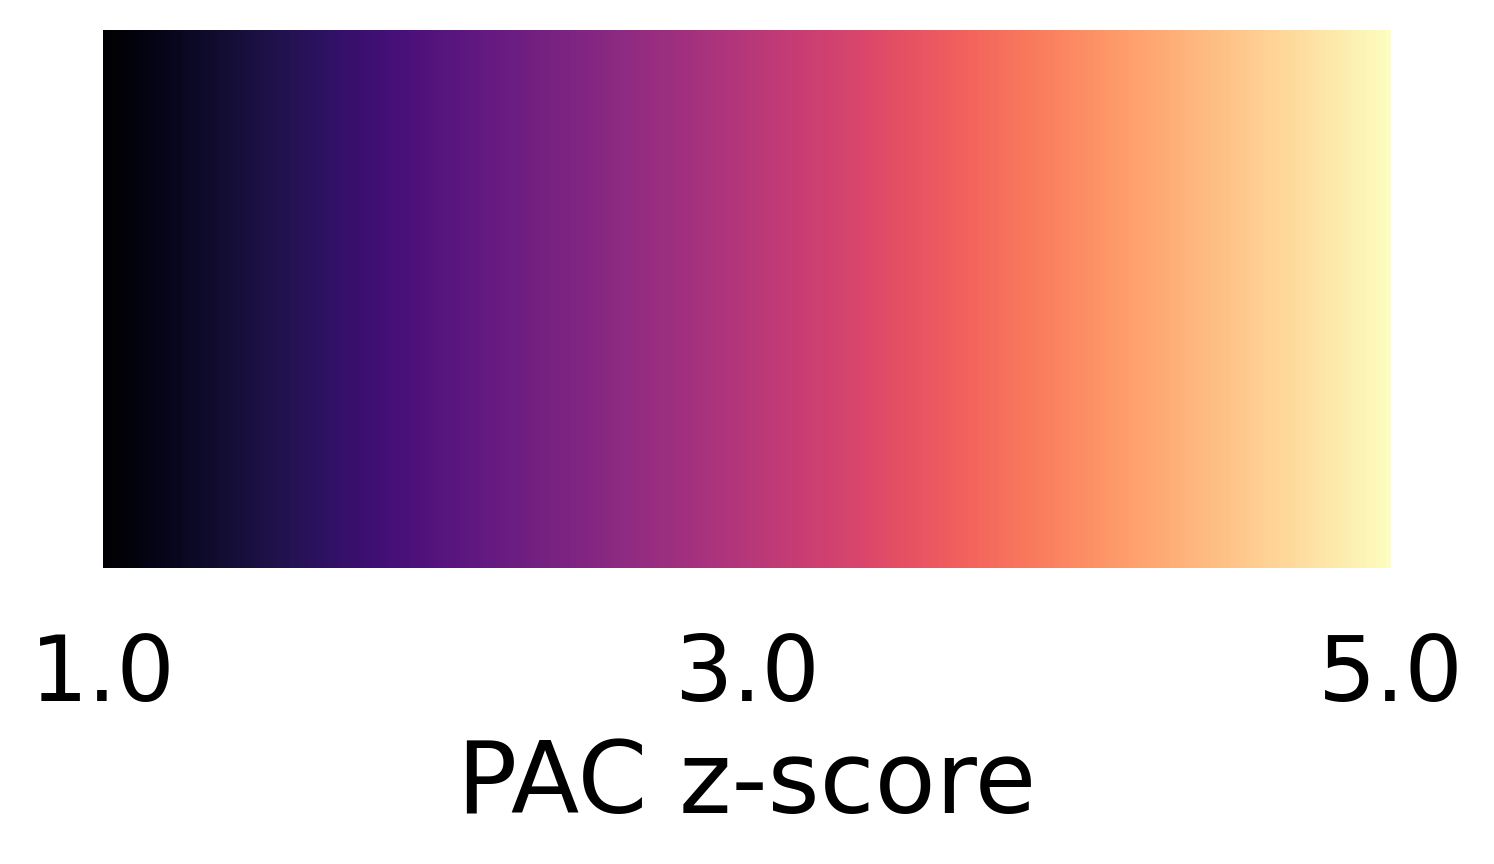

Colorbar saved as: colorbar_vmin_1_vmid_3_vmax_5.png and colorbar_vmin_1_vmid_3_vmax_5.pdf


In [74]:
# Create colorbar
vmin, vmid, vmax = 1, 3, 5
try:
    fig, ax = create_colorbar(vmin, vmid, vmax)
    
    # Save colorbar
    colorbar_name = f"colorbar_vmin_{vmin}_vmid_{vmid}_vmax_{vmax}"
    fig.savefig(f"{colorbar_name}.png", transparent=True, dpi=300, bbox_inches='tight')
    fig.savefig(f"{colorbar_name}.pdf", transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Colorbar saved as: {colorbar_name}.png and {colorbar_name}.pdf")
except Exception as e:
    print(f"Error creating colorbar: {e}")
    print("Creating simple colorbar instead...")
    
    # Simple colorbar creation
    fig, ax = plt.subplots(figsize=(6, 1))
    cmap = plt.cm.magma
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                       cax=ax, orientation='horizontal')
    cbar.set_label('PAC z-score')
    plt.tight_layout()
    plt.show()